In [139]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer

In [140]:
df = pd.read_csv('../data/external/5-Minute Crafts.csv')

In [141]:
df.head()

,video_id,title,active_since_days,duration_seconds,total_views,num_chars,num_words,num_punctuation,num_words_uppercase,num_words_lowercase,num_stopwords,avg_word_len,contain_digits,startswith_digits,title_sentiment
0,v=lCePSP4lb-k,Wow! Let's go live! Epic decorations and DIYS,1,558,10825,45,8,3,1,4,1,5.625000,0,0,0.131818
1,v=G7O9iWWOtTY,EXTREME ROOM TRANSFORMATION || Cool Design Ide...,1,1020,184374,63,10,2,3,0,2,6.300000,0,0,0.112500
2,v=cd0u5IFxBdo,LATE SUMMER HACKS TO SAVE YOUR DAY,2,629,478170,34,7,0,7,0,2,4.857143,0,0,-0.300000
3,v=lWSXHFPqBfo,EVERY SMART PARENT KNOWS THESE USEFUL HACKS #s...,2,41,197359,51,8,1,7,1,1,6.375000,0,0,0.257143
4,v=qqPFeyd84Lg,SMART HACKS TO SAVE YOUR WEDDING DAY🤵‍👰‍💍🕊️,3,784,162025,43,7,0,7,0,2,6.142857,0,0,0.214286


In [142]:
df.shape

(4904, 15)

In [143]:
len(df.video_id.unique())

4904

In [144]:
len(df.title.unique())

4892

In [145]:
df.isnull().values.any()

False

[Text(0.5, 0, 'Active days since'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Accumalated distribution of Active days since')]

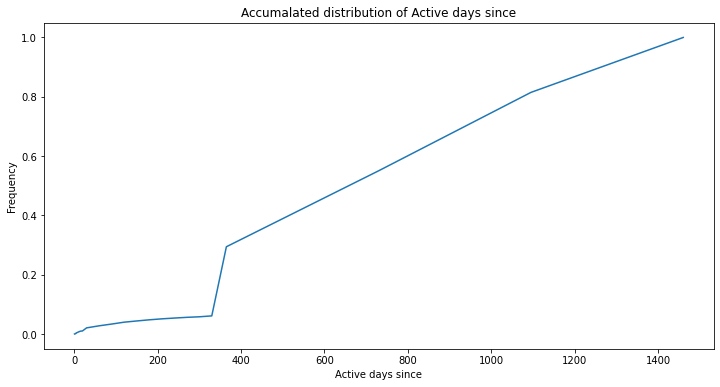

In [146]:
accumulated_percent = df.active_since_days.value_counts().sort_index() / df.active_since_days.count()
accumulated_percent = accumulated_percent.cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(accumulated_percent.index, accumulated_percent)
ax.set(xlabel="Active days since",
       ylabel="Frequency",
       title="Accumalated distribution of Active days since")

In [147]:
accumulated_percent

1       0.000408
2       0.000816
3       0.001223
4       0.001427
5       0.004078
6       0.004282
10      0.006933
15      0.009788
20      0.010604
30      0.021003
60      0.027936
90      0.033850
120     0.040171
150     0.044250
180     0.048124
210     0.051387
240     0.054038
270     0.056485
300     0.058320
330     0.061378
365     0.294454
730     0.550571
1095    0.814845
1460    1.000000
Name: active_since_days, dtype: float64

In [148]:
df = df[df.active_since_days >= 365]
df.shape

(4603, 15)

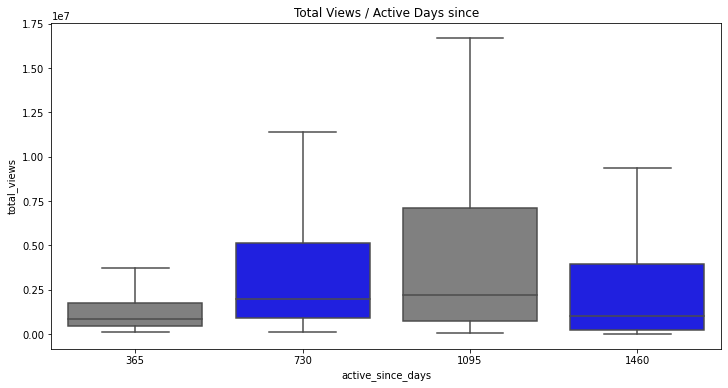

In [149]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="active_since_days", y="total_views",
                 data=df, ax = ax, palette=['gray','blue'], showfliers=False)

[Text(0.5, 0, 'Duration seconds'),
 Text(0, 0.5, 'Frequency'),
 Text(0.5, 1.0, 'Accumalated distribution of duration')]

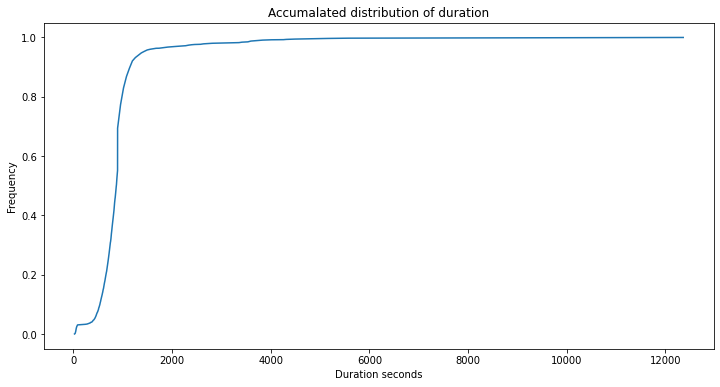

In [150]:
accumulated_percent = df.duration_seconds.value_counts().sort_index() / df.duration_seconds.count()
accumulated_percent = accumulated_percent.cumsum()

fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(accumulated_percent.index, accumulated_percent)
ax.set(xlabel="Duration seconds",
       ylabel="Frequency",
       title="Accumalated distribution of duration")

In [151]:
df.reset_index(inplace=True, drop=True)

## Feature Engineering

In [152]:
original_features = df.columns

In [153]:
df['title'] = df.title.str.lower()

tokenizer = nltk.RegexpTokenizer(r"\b\d+\b")
df['num_digits'] = df.title.apply(lambda x: len(tokenizer.tokenize(x)))

nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')
vectorizer = TfidfVectorizer(stop_words=stopwords, token_pattern=r"\b[^\d\W]+\b")


[nltk_data] Downloading package stopwords to /home/julio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Some video title uses the letter 'l' as the pipe character "|"

In [154]:
sdf = pd.DataFrame.sparse.from_spmatrix(vectorizer.fit_transform(df.title),
                         columns=vectorizer.get_feature_names())
df = df.join(sdf)

/home/julio/.local/share/virtualenvs/5-minute-craft-titles-lBIm3JLI/lib/python3.8/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [171]:
cols_to_drop = ['video_id','title']
X = df.drop(cols_to_drop, axis=1)

X = StandardScaler().fit_transform(X)

/home/julio/.local/share/virtualenvs/5-minute-craft-titles-lBIm3JLI/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/home/julio/.local/share/virtualenvs/5-minute-craft-titles-lBIm3JLI/lib/python3.8/site-packages/sklearn/utils/validation.py:616: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [206]:
cols_weight = ['total_views','active_since_days']
p = 4

for col in cols_weight:
    index = list(df.columns).index(col) - len(cols_to_drop)
    X[:,index] *= p 

In [207]:
kmeans = KMeans(4)
df['cluster'] = kmeans.fit_predict(X)

In [208]:
df.cluster.value_counts()

2    2308
0    1994
1     282
3      19
Name: cluster, dtype: int64

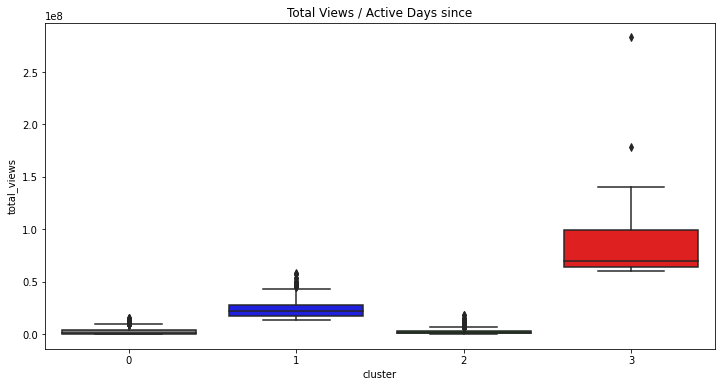

In [209]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="cluster", y="total_views",
                 data=df, ax = ax, palette=['gray','blue','green','red'])

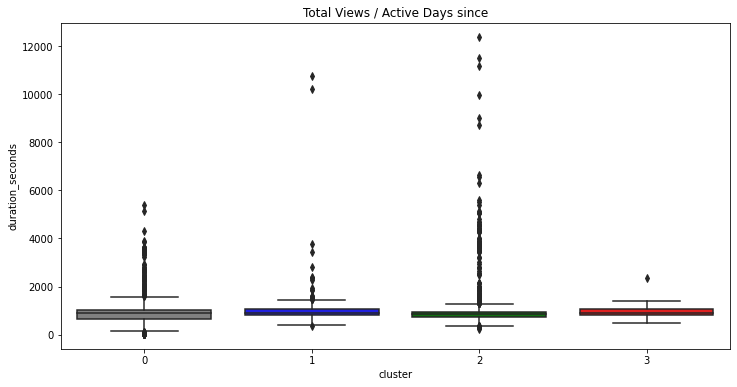

In [210]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Total Views",
       ylabel="Active Days Since",
       title="Total Views / Active Days since")

ax = sns.boxplot(x="cluster", y="duration_seconds",
                 data=df, ax = ax, palette=['gray','blue','green','red'])

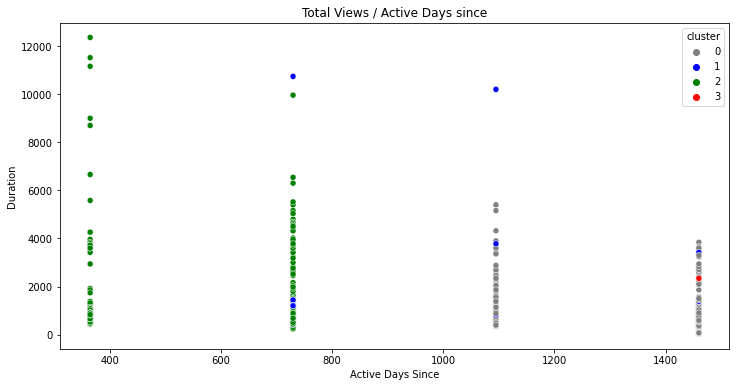

In [211]:
fig, ax = plt.subplots(figsize=(12, 6))
ax.set(xlabel="Active Days Since",
       ylabel="Duration",
       title="Total Views / Active Days since")

ax = sns.scatterplot(x="active_since_days", y="duration_seconds",hue="cluster",
                 data=df, ax = ax, palette=['gray','blue','green','red'])

In [222]:
for c in df.cluster.unique().sort_values():
    print(f'Evaluating most frequent words for cluster: {c}')
    cluster_data = df[df.cluster == c].copy()
    print(cluster_data.drop(list(original_features)+['cluster','num_digits'], axis=1).sum().sort_values()[-10::])


Evaluating most frequent words for cluster: 2
try        56.487183
know       57.493648
cool       57.894758
beauty     62.579584
diy        67.601554
tricks     70.115836
crazy      72.417234
life      101.165320
ideas     115.274594
hacks     199.640144
dtype: float64
Evaluating most frequent words for cluster: 1
ideas      6.139481
save       6.209223
genius     6.756338
crazy      6.884046
tricks     7.145674
cool       7.339494
make       7.633083
beauty    10.180335
life      21.029921
hacks     30.293503
dtype: float64
Evaluating most frequent words for cluster: 3
balloons    0.807461
lips        0.812059
amazing     0.812653
make        0.999182
simple      1.168716
look        1.202566
every       1.291138
day         1.398810
life        2.004799
hacks       2.386440
dtype: float64
Evaluating most frequent words for cluster: 0
l          46.006868
know       49.519517
easy       50.778465
tricks     52.079882
tips       52.585779
minute     55.888191
make       55.939605
craf

In [213]:
1

1